<a href="https://colab.research.google.com/github/smfwlgus/DnM/blob/master/LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#코드 및 데이터 참고: https://dacon.io/competitions/official/235801/overview/description

# **라이브러리**

In [2]:
import numpy as np 
import pandas as pd
from tqdm import tqdm

import datetime
import urllib.request
import json

from glob import glob
import multiprocessing
import pickle

import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm
from lightgbm import LGBMRegressor

In [3]:
# 경고 끄기
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')  #관련없는 문구 알리지 않음

# **어제 정보 가져와서 처리**

In [ ]:
#어제의 농넷 데이터 불러오기
#datetime.datetime(2019, 12, 12)...
today = datetime.datetime.today()
yesterday = (today-datetime.timedelta(1)).strftime('%Y%m%d') #strftime(): 원하는 날짜 형식으로 출력

url = 'https://www.nongnet.or.kr/api/whlslDstrQr.do?sdate=' # sdate = 날짜

response = urllib.request.urlopen(url+yesterday).read()
response = json.loads(response)

data = pd.DataFrame(response['data'])

In [ ]:
yesterday

'20211206'

In [ ]:
data

,PUM_NM,LV_NM,TOT_AMT,SAN_NM,SALEDATE,CMP_NM,DAN_NM,WHSAL_NM,SIZE_NM,COST,POJ_NM,TOT_QTY,QTY,KIND_NM,DANQ
0,생강,.,372000,전북 익산시,20211206,이리청과,kg,익산도매시장,.,3100,상자,120.0,120.0,생강(일반),1.0
1,생강,.,49600,전북 익산시,20211206,이리청과,.,익산도매시장,.,3100,.,16.0,16.0,생강(일반),1.0
2,건고추,.,160000,전북 익산시,20211206,이리청과,kg,익산도매시장,.,8000,상자,20.0,20.0,기타건고추,1.0
3,건고추,.,280000,전북 익산시,20211206,이리청과,.,익산도매시장,.,7000,.,40.0,40.0,기타건고추,1.0
4,건고추,.,260000,전북 익산시,20211206,이리청과,kg,익산도매시장,.,6500,상자,40.0,40.0,기타건고추,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108856,바나나,.,160000,None,20211206,강서청과,kg,서울강서도매,1개(내_뿌리),16000,.,130.0,10.0,바나나(수입),13.0
108857,바나나,.,80000,None,20211206,강서청과,kg,서울강서도매,1개(내_뿌리),16000,.,65.0,5.0,바나나(수입),13.0
108858,바나나,.,80000,None,20211206,강서청과,kg,서울강서도매,1개(내_뿌리),16000,.,65.0,5.0,바나나(수입),13.0
108859,상추,.,-160000,None,20211206,강서청과,kg,서울강서도매,1개(내_뿌리),10000,상자,-64.0,-16.0,포기찹,4.0


In [ ]:
data.to_csv(f'/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/AT_TSALET_ALL_{yesterday}.csv', index=False)

In [ ]:
# 윈도우즈 사용시 함수를 별도의 .py파일로 저장 후 import하여 사용
def preprocessing(tsalet_file):
    unique_pum = [
        '배추', '무', '양파', '마늘', '대파', 
        '깻잎', '시금치', '미나리', '파프리카', '토마토',
    ]
    
    t_dict = {
        'date':[]
    }
    
    for sub in unique_pum:
        t_dict[f'{sub}_거래량(kg)'] = []
        t_dict[f'{sub}_가격(원/kg)'] = []
        
    tsalet_sample = pd.read_csv(tsalet_file)
    days = sorted(tsalet_sample['SALEDATE'].unique())
    for day in days:
        t_dict['date'].append(day)
        for sub in unique_pum:
            # 날짜별, 품목별, 거래량이 0 이상인 행만 선택
            c = tsalet_sample[(tsalet_sample['SALEDATE']==day) & (tsalet_sample['PUM_NM']==sub) & (tsalet_sample['TOT_QTY']>=0)]
            if c.shape[0] == 0:
                t_dict[f'{sub}_거래량(kg)'].append(0)
                t_dict[f'{sub}_가격(원/kg)'].append(0)
            else:
                tot_amt = c['TOT_AMT'].sum().astype(float)
                tot_qty = c['TOT_QTY'].sum().astype(float)
                mean_price = tot_amt/(tot_qty+1e-20)
                t_dict[f'{sub}_거래량(kg)'].append(tot_qty)
                t_dict[f'{sub}_가격(원/kg)'].append(mean_price)
                
    with open(f'/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/{tsalet_file.split("/")[-1].split(".")[0]}.pkl', 'wb') as f:
        pickle.dump(t_dict, f)

In [ ]:
#tsalet_files = sorted(glob('/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/*'))
tsalet_files = sorted(glob(f'/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/AT_TSALET_ALL_{yesterday}.csv')) 

pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
pool.map(preprocessing, tsalet_files)
pool.close()
pool.join()

In [ ]:
dict_files = sorted(glob(f'/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/AT_TSALET_ALL_{yesterday}.pkl'))

In [ ]:
t_dict_list = []
for dict_file in dict_files:
    with open(dict_file, 'rb') as f:
        train_dict = pickle.load(f)
    t_dict_list.append(train_dict)

In [ ]:
train = None

for t_dcit in t_dict_list:
    if train is None:
        train = pd.DataFrame(t_dcit)
    else:
        train = pd.concat([train, pd.DataFrame(t_dcit)])

In [ ]:
train['date'] = train.date.astype(str).str.replace('-','')
train['date'] = pd.to_datetime(train.date, format='%Y%m%d')

In [ ]:
train.insert(1, '요일', '0')

In [ ]:
import datetime #20/9/29~20/11/5
days = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

for i in range (train.shape[0]): #문자 -> 숫자
  train['요일'][i] = days[int(train['date'].dt.weekday[i])]

train['date'] = train['date'].dt.date

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Capstone/Data/test_yesterday.csv')

test = test.append(train)
test

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),대파_거래량(kg),대파_가격(원/kg),깻잎_거래량(kg),깻잎_가격(원/kg),시금치_거래량(kg),시금치_가격(원/kg),미나리_거래량(kg),미나리_가격(원/kg),파프리카_거래량(kg),파프리카_가격(원/kg),토마토_거래량(kg),토마토_가격(원/kg)
0,2021-01-01,금요일,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,2021-01-02,토요일,24401.5,388.534188,21461.0,559.526583,20606.0,1058.393186,2408.0,5129.931063,27859.0,2384.020245,4079.5,13150.276995,9920.00,2642.957863,7033.0,1614.409498,7849.0,4884.721875,25290.0,1914.895216
2,2021-01-03,일요일,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,2021-01-04,월요일,859651.8,441.499637,1665261.7,542.826183,1823037.4,1266.627437,121200.4,5425.898627,874594.6,2202.568178,112324.7,9501.869972,374131.63,2966.183666,79020.5,3509.511798,150290.6,4515.337752,393979.0,2098.278649
4,2021-01-05,화요일,889332.2,412.451877,1647835.5,570.874791,1513826.0,1329.721668,125712.0,5147.233605,765322.2,2240.754967,69850.2,11128.609839,295523.20,3111.929321,74112.0,3965.334750,89124.0,5515.671581,228576.5,2092.442574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2021-12-01,수요일,1517157.5,814.134951,1515337.4,355.843013,1713024.7,804.114206,159602.7,6826.912909,513202.7,1398.334826,61748.9,6717.704607,220261.97,2417.830949,86655.6,6068.800828,162380.7,2134.811434,190878.7,2507.076484
335,2021-12-02,목요일,1517168.6,854.298249,955693.7,395.180976,1586469.1,773.716986,93316.7,6752.165754,515073.5,1459.508031,60809.6,6067.539204,169262.65,2258.844447,46633.5,5603.047616,125224.1,2245.025486,123034.5,2424.799223
336,2021-12-03,금요일,2240760.1,886.985342,1502845.2,455.352038,1614193.9,796.582220,132291.6,6445.476259,553619.6,1438.332909,60559.5,6088.198383,216081.30,2515.163681,76514.6,6814.752805,125767.1,2311.520573,183210.9,2505.971260
337,2021-12-04,토요일,2252554.0,852.102393,1775656.7,418.328377,1310767.6,757.764336,56641.0,6619.346233,555779.5,1450.834471,62114.3,6265.478078,225897.60,2573.332784,81923.3,7598.718924,94772.4,2563.595118,167333.0,2322.273132


test, test_files 만들기

In [ ]:
test.to_csv('/content/drive/MyDrive/Capstone/Data/test_yesterday.csv', index=False)

In [ ]:
yes = (today-datetime.timedelta(1)).strftime('%Y-%m-%d')
test.to_csv(f'/content/drive/MyDrive/Capstone/Data/test_files/test_{yes}.csv', index=False)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Capstone/Data/subsub.csv') #12/3

In [ ]:
for week_num in [1,2,4]:
  yes = (today-datetime.timedelta(1)).strftime('%Y-%m-%d')
  submission.loc[len(submission)] = [f'{yes}+{week_num}week', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #어제꺼 가져와서 돌리는 경우 필요

In [ ]:
submission

,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),깻잎_가격(원/kg),시금치_가격(원/kg),미나리_가격(원/kg),파프리카_가격(원/kg),토마토_가격(원/kg)
0,2021-01-01+1week,0,0,0,0,0,0,0,0,0,0
1,2021-01-01+2week,0,0,0,0,0,0,0,0,0,0
2,2021-01-01+4week,0,0,0,0,0,0,0,0,0,0
3,2021-01-02+1week,0,0,0,0,0,0,0,0,0,0
4,2021-01-02+2week,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1012,2021-12-04+2week,0,0,0,0,0,0,0,0,0,0
1013,2021-12-04+4week,0,0,0,0,0,0,0,0,0,0
1014,2021-12-06+1week,0,0,0,0,0,0,0,0,0,0
1015,2021-12-06+2week,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission.to_csv('/content/drive/MyDrive/Capstone/Data/subsub.csv', index = False)

# **EDA**

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Capstone/Data/ten_pum_train_onebon.csv')
train = train[:1827] #2016 1 ~ 2020 12

In [5]:
train.head()

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),대파_거래량(kg),대파_가격(원/kg),깻잎_거래량(kg),깻잎_가격(원/kg),시금치_거래량(kg),시금치_가격(원/kg),미나리_거래량(kg),미나리_가격(원/kg),파프리카_거래량(kg),파프리카_가격(원/kg),토마토_거래량(kg),토마토_가격(원/kg)
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-02,토요일,80860.0,329.0,80272.0,360.0,122787.5,1281.0,15019.0,5475.0,92334.0,1704.0,4374.9,13242.0,16550.5,2339.0,10528.0,1729.0,3853.0,3703.0,30950.0,1621.0
2,2016-01-03,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-04,월요일,1422742.5,478.0,1699653.7,382.0,2315079.0,1235.0,141638.0,5210.0,994328.1,1716.0,122613.5,9923.0,427435.1,2153.0,82113.5,3960.0,104930.3,4871.0,291057.0,1834.0
4,2016-01-05,화요일,1167241.0,442.0,1423482.3,422.0,2092960.1,1213.0,126207.8,5387.0,787716.0,1715.0,79055.9,9529.0,334636.8,2220.0,80144.0,3333.0,100699.5,5129.0,194626.5,1833.0


In [6]:
weather = pd.read_csv('/content/drive/MyDrive/Capstone/주산지, 날씨 코드/weather.csv')
weather.head() #2015~2020 날씨 데이터

,no,stn_Code,stn_Name,date,temp,max_Temp,min_Temp,hum,widdir,wind,rain,sun_Time,sun_Qy,condens_Time,gr_Temp,soil_Temp,soil_Wt
0,1,536824B002,해남군 옥천면,2015-01-01,-1.3,0.6,-2.9,80.0,295.2,2.3,0.8,NaN,7.8,NaN,NaN,3.36,25.9
1,1,330846A001,천안시 목천읍,2015-01-01,-6.2,-3.8,-8.3,NaN,NaN,0.0,0.0,NaN,NaN,1429.0,NaN,NaN,NaN
2,1,627911A001,밀양시 상남면,2015-01-01,-3.2,0.2,-7.2,40.1,282.7,2.9,0.0,516.0,11.0,0.0,NaN,2.20,28.5
3,1,539823A001,진도군 군내면,2015-01-01,-0.8,1.6,-2.8,79.2,257.0,3.5,1.5,217.0,8.2,652.0,NaN,5.02,30.6
4,1,590823A001,남원시 이백면,2015-01-01,-4.1,-1.3,-6.0,60.7,286.7,2.1,0.5,310.0,7.7,0.0,-4.3,2.16,20.3


# **전처리**
lag_feature 추가 및 기타 전처리

*   f-string 포맷팅: f '문자열 {변수} 문자열'로 사용
    - 문자열에서 모두 같고 특정 부분만 바뀔때 사용




**전처리1. lag_feature 추가 및 기타**

In [7]:
def preprocessing(temp_df, pum, len_lag) :
    # p_lag, q_lag 추가
    for lag in range(1,len_lag+1) :
      temp_df[f'p_lag_{lag}'] = -1
      temp_df[f'q_lag_{lag}'] = -1
      for index in range(lag, len(temp_df)) :
        temp_df.loc[index, f'p_lag_{lag}'] = temp_df[f'{pum}_가격(원/kg)'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
        temp_df.loc[index, f'q_lag_{lag}'] = temp_df[f'{pum}_거래량(kg)'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가

    # month 추가
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    temp_df['month'] = temp_df['date'].dt.month

    # 예측 대상(1w,2w,4w) 추가
    for week in ['1_week','2_week','4_week'] :
      temp_df[week] = 0
      n_week = int(week[0])
      for index in range(len(temp_df)) :
        try : temp_df[week][index] = temp_df[f'{pum}_가격(원/kg)'][index+7*n_week]
        except : continue

    # 불필요한 column 제거        
    #temp_df = temp_df.drop(['date',f'{pum}_거래량(kg)',f'{pum}_가격(원/kg)'], axis=1)
    
    return temp_df

In [8]:
# preprocessing 함수 예시
pum = '배추'
temp_pre = train[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']]
preprocessing(temp_pre, pum, len_lag=28)

,date,배추_거래량(kg),배추_가격(원/kg),p_lag_1,q_lag_1,p_lag_2,q_lag_2,p_lag_3,q_lag_3,p_lag_4,q_lag_4,p_lag_5,q_lag_5,p_lag_6,q_lag_6,p_lag_7,q_lag_7,p_lag_8,q_lag_8,p_lag_9,q_lag_9,p_lag_10,q_lag_10,p_lag_11,q_lag_11,p_lag_12,q_lag_12,p_lag_13,q_lag_13,p_lag_14,q_lag_14,p_lag_15,q_lag_15,p_lag_16,q_lag_16,p_lag_17,q_lag_17,p_lag_18,q_lag_18,p_lag_19,q_lag_19,p_lag_20,q_lag_20,p_lag_21,q_lag_21,p_lag_22,q_lag_22,p_lag_23,q_lag_23,p_lag_24,q_lag_24,p_lag_25,q_lag_25,p_lag_26,q_lag_26,p_lag_27,q_lag_27,p_lag_28,q_lag_28,month,1_week,2_week,4_week
0,2016-01-01,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,420,449,625
1,2016-01-02,80860.0,329.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,389,454,733
2,2016-01-03,0.0,0.0,329.0,80860.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,0,1048
3,2016-01-04,1422742.5,478.0,0.0,0.0,329.0,80860.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,398,475,638
4,2016-01-05,1167241.0,442.0,478.0,1422742.5,0.0,0.0,329.0,80860.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,431,511,597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2020-12-27,0.0,0.0,450.0,490145.7,333.0,943971.2,390.0,871832.2,349.0,1134505.8,536.0,1138784.6,382.0,1410380.0,0.0,0.0,478.0,643176.5,586.0,799981.4,418.0,467021.1,520.0,480593.7,397.0,853897.4,402.0,1616640.0,0.0,0.0,414.0,1606711.4,459.0,1846148.6,421.0,1271225.1,369.0,1504625.2,429.0,1809895.9,419.0,2491906.3,0.0,0.0,499.0,2301403.5,546.0,2780896.6,452.0,1999870.1,424.0,2101909.6,384.0,2409404.6,433.0,3554050.5,0.0,0.0,12,0,0,0
1823,2020-12-28,887951.6,428.0,0.0,0.0,450.0,490145.7,333.0,943971.2,390.0,871832.2,349.0,1134505.8,536.0,1138784.6,382.0,1410380.0,0.0,0.0,478.0,643176.5,586.0,799981.4,418.0,467021.1,520.0,480593.7,397.0,853897.4,402.0,1616640.0,0.0,0.0,414.0,1606711.4,459.0,1846148.6,421.0,1271225.1,369.0,1504625.2,429.0,1809895.9,419.0,2491906.3,0.0,0.0,499.0,2301403.5,546.0,2780896.6,452.0,1999870.1,424.0,2101909.6,384.0,2409404.6,433.0,3554050.5,12,0,0,0
1824,2020-12-29,701531.2,417.0,428.0,887951.6,0.0,0.0,450.0,490145.7,333.0,943971.2,390.0,871832.2,349.0,1134505.8,536.0,1138784.6,382.0,1410380.0,0.0,0.0,478.0,643176.5,586.0,799981.4,418.0,467021.1,520.0,480593.7,397.0,853897.4,402.0,1616640.0,0.0,0.0,414.0,1606711.4,459.0,1846148.6,421.0,1271225.1,369.0,1504625.2,429.0,1809895.9,419.0,2491906.3,0.0,0.0,499.0,2301403.5,546.0,2780896.6,452.0,1999870.1,424.0,2101909.6,384.0,2409404.6,12,0,0,0
1825,2020-12-30,1034279.0,482.0,417.0,701531.2,428.0,887951.6,0.0,0.0,450.0,490145.7,333.0,943971.2,390.0,871832.2,349.0,1134505.8,536.0,1138784.6,382.0,1410380.0,0.0,0.0,478.0,643176.5,586.0,799981.4,418.0,467021.1,520.0,480593.7,397.0,853897.4,402.0,1616640.0,0.0,

**weather의 이상치, 결측치 처리하기**

In [9]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34263 entries, 0 to 34262
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   no            34263 non-null  int64  
 1   stn_Code      34263 non-null  object 
 2   stn_Name      34263 non-null  object 
 3   date          34263 non-null  object 
 4   temp          34258 non-null  float64
 5   max_Temp      34258 non-null  float64
 6   min_Temp      34227 non-null  float64
 7   hum           33518 non-null  float64
 8   widdir        30691 non-null  float64
 9   wind          34263 non-null  float64
 10  rain          34255 non-null  float64
 11  sun_Time      23537 non-null  float64
 12  sun_Qy        33610 non-null  float64
 13  condens_Time  28002 non-null  float64
 14  gr_Temp       18895 non-null  float64
 15  soil_Temp     29585 non-null  float64
 16  soil_Wt       17250 non-null  float64
dtypes: float64(13), int64(1), object(3)
memory usage: 4.4+ MB


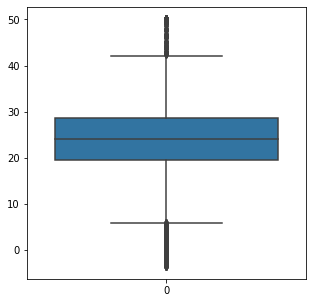

In [10]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=weather['soil_Wt'])

In [11]:
weather = weather.drop(['sun_Time', 'condens_Time', 'gr_Temp', 'soil_Wt'] , 1)

In [12]:
weather.fillna(0, inplace=True)

In [13]:
weather.isnull().sum()

no           0
stn_Code     0
stn_Name     0
date         0
temp         0
max_Temp     0
min_Temp     0
hum          0
widdir       0
wind         0
rain         0
sun_Qy       0
soil_Temp    0
dtype: int64

**전처리2. 기상 변수 추가**

*   30일씩 12쿼터로 나누어서 평균 기온, 평균 습도, 누적 강수량, 이상 기후 누적 일수 등 추가  
* 3개월씩 계절별로 끊어서 학습하는 것도 고려



In [14]:
#10개 품목의 주산지
joosan_dict = {
    '깻잎': '경상남도 밀양시',
    '대파': '전라남도 진도군',
    '마늘': '경상남도 창녕군',
    '무': '제주도 제주시',
    '미나리': '경기도 시흥시',
    '배추': '전라남도 해남군',
    '시금치': '경기도 포천시',
    '양파': '전라남도 무안군',
    '토마토': '부산 강서구',
    '파프리카': '강원도 철원군'         
}

In [15]:
#10개 품목의 주산지 관측지점 코드
code_dict = { 
    '강원도 철원군': '269811A001', #파프리카
    '경기도 시흥시': '429843A001', #미나리
    '경기도 포천시': '487915A001', #시금치
    '경상남도 밀양시': '627911A001', #깻잎
    '경상남도 창녕군': '635821A001', #마늘
    '부산 강서구': '618803A001', #토마토
    '전라남도 무안군': '534833E001', #양파
    '전라남도 진도군': '539823A001', #대파
    '전라남도 해남군': '536824B002', #배추
    '제주도 제주시': '063057B009', #무
}

In [16]:
first_date = datetime.datetime.strptime('2020-09-28', '%Y-%m-%d') - datetime.timedelta(360) 
date_list = [] 
for delta in range(360) : #0~360
    date = first_date + datetime.timedelta(days = delta)
    date = datetime.datetime.strftime(date, '%Y-%m-%d') 
    date_list.append(date)
date_df = pd.DataFrame({'date' : date_list}) #date가 담긴 df 생성
train = pd.read_csv('/content/drive/MyDrive/Capstone/Data/ten_pum_train_onebon.csv')
train = train[:1827] #2016 1 ~ 2020 12
train2 = pd.concat([date_df, train], sort = False).reset_index(drop=True) #1년치, 전체날짜(train)

In [17]:
def weather_feature(temp_df, train2, date_df, allweather, pum, joosan_dict, code_dict, quater_days=30, num_quaters=12):
    # 2015년도 일자 추가
    temp_df = train2[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']]
    
    # 품종과 주산지 날씨 mapping
    joosanji = joosan_dict[pum]
    joosan_code = code_dict[joosanji]
    joosan_weather = allweather[allweather['stn_Code']==joosan_code].reset_index(drop=True)
    end_index = np.where(joosan_weather['date']=='2020-12-31')[0][0]
    joosan_weather = joosan_weather.iloc[:end_index+1] #2020-09-28 까지만 자르기
    temp_df = temp_df.merge(joosan_weather, on='date', how='left')

    # weather feature 추가
    col_list = temp_df.columns[6:]
    for num in range(1,num_quaters+1) :
        for index in range(360, len(temp_df)) :
            temp_quater_df = temp_df.iloc[index-quater_days*num : index-quater_days*(num-1)] #
            quater_temp = temp_quater_df['temp']
            temp_df.loc[index, f'rain_sum_{num}q'] = temp_quater_df['rain'].sum() # 누적 강수량
            temp_df.loc[index, f'heavy_rain_count_{num}q'] = np.where(temp_quater_df['rain']>90, 1, 0).sum() # 평균 강수량 90mm 이상 누적 일수
            temp_df.loc[index, f'low_temp_count_{num}q'] = np.where(quater_temp<5, 1, 0).sum() # 일평균 기온 5도 이하 누적 일수
            temp_df.loc[index, f'middle_temp_count_{num}q'] = np.where(((quater_temp>15)&(quater_temp<22)), 1, 0).sum() # 일평균 기온 15~22도 누적 일수
            temp_df.loc[index, f'high_temp_count_{num}q'] = np.where(quater_temp>32, 1, 0).sum() # 일평균 기온 32도 이상 누적 일수
            for col in col_list :
                temp_df.loc[index, f'avg_{col}_{num}q'] = temp_quater_df[col].mean() # 각 기상 요소의 평균값
        
    # 예측 대상(1w,2w,4w) 추가
    for week in ['1_week','2_week','4_week'] :
      temp_df[week] = 0
      n_week = int(week[0])
      for index in range(len(temp_df)) :
        try : temp_df[week][index] = temp_df[f'{pum}_가격(원/kg)'][index+7*n_week]
        except : continue

    drop_col_list = temp_df.columns[3:19]
    temp_df = temp_df.drop(drop_col_list, 1).reset_index(drop=True)
    temp_df = temp_df.iloc[360:].reset_index(drop=True)     
    temp_df = temp_df.drop(['date',f'{pum}_거래량(kg)',f'{pum}_가격(원/kg)'], axis=1) # 불필요한 column 제거 
    
    return temp_df

In [18]:
# weather_feature 함수 예시
pum = '배추'
temp_df = train[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']]
weather_feature(temp_df, train2, date_df, weather, pum, joosan_dict, code_dict, quater_days=30, num_quaters=12)

,high_temp_count_1q,avg_temp_1q,avg_max_Temp_1q,avg_min_Temp_1q,avg_hum_1q,avg_widdir_1q,avg_wind_1q,avg_rain_1q,avg_sun_Qy_1q,avg_soil_Temp_1q,rain_sum_2q,heavy_rain_count_2q,low_temp_count_2q,middle_temp_count_2q,high_temp_count_2q,avg_temp_2q,avg_max_Temp_2q,avg_min_Temp_2q,avg_hum_2q,avg_widdir_2q,avg_wind_2q,avg_rain_2q,avg_sun_Qy_2q,avg_soil_Temp_2q,rain_sum_3q,heavy_rain_count_3q,low_temp_count_3q,middle_temp_count_3q,high_temp_count_3q,avg_temp_3q,avg_max_Temp_3q,avg_min_Temp_3q,avg_hum_3q,avg_widdir_3q,avg_wind_3q,avg_rain_3q,avg_sun_Qy_3q,avg_soil_Temp_3q,rain_sum_4q,heavy_rain_count_4q,...,avg_temp_10q,avg_max_Temp_10q,avg_min_Temp_10q,avg_hum_10q,avg_widdir_10q,avg_wind_10q,avg_rain_10q,avg_sun_Qy_10q,avg_soil_Temp_10q,rain_sum_11q,heavy_rain_count_11q,low_temp_count_11q,middle_temp_count_11q,high_temp_count_11q,avg_temp_11q,avg_max_Temp_11q,avg_min_Temp_11q,avg_hum_11q,avg_widdir_11q,avg_wind_11q,avg_rain_11q,avg_sun_Qy_11q,avg_soil_Temp_11q,rain_sum_12q,heavy_rain_count_12q,low_temp_count_12q,middle_temp_count_12q,high_temp_count_12q,avg_temp_12q,avg_max_Temp_12q,avg_min_Temp_12q,avg_hum_12q,avg_widdir_12q,avg_wind_12q,avg_rain_12q,avg_sun_Qy_12q,avg_soil_Temp_12q,1_week,2_week,4_week
0,0.0,21.116667,26.186667,17.276667,91.950000,188.980000,0.473333,8.316667,12.863333,24.163333,168.0,0.0,0.0,0.0,0.0,26.743333,31.020000,23.610000,93.443333,162.580000,0.736667,5.600000,15.130000,27.260667,362.0,1.0,0.0,17.0,0.0,21.860000,25.610000,19.150000,95.990000,167.516667,0.540000,12.066667,10.040000,23.234667,329.0,1.0,...,2.850000,9.130000,-3.320000,78.283333,258.353333,0.683333,0.516667,7.963333,6.961667,44.5,0.0,5.0,1.0,0.0,8.620000,15.126667,2.350000,80.323333,250.700000,0.713333,1.483333,9.413333,12.410333,9.0,0.0,0.0,13.0,0.0,14.350000,21.443333,8.353333,84.096667,242.513333,0.453333,0.300000,13.353333,18.095667,420.0,449.0,625.0
1,0.0,20.313333,25.496667,16.306667,91.423333,194.536667,0.466667,7.770000,12.856667,23.400333,183.5,0.0,0.0,0.0,0.0,26.720000,30.966667,23.590000,93.480000,162.286667,0.743333,6.116667,14.920000,27.316333,360.5,1.0,0.0,16.0,0.0,22.083333,25.936667,19.360000,96.040000,163.790000,0.510000,12.016667,10.243333,23.347333,315.0,1.0,...,2.723333,9.093333,-3.456667,78.720000,258.250000,0.676667,0.516667,8.050000,6.815333,44.5,0.0,6.0,1.0,0.0,8.313333,14.720000,2.033333,79.916667,250.610000,0.720000,1.483333,9.270000,12.194333,9.0,0.0,0.0,12.0,0.0,14.086667,21.213333,8.026667,83.833333,248.693333,0.456667,0.300000,13.246667,17.854667,389.0,454.0,733.0
2,0.0,19.596667,24.846667,15.513333,91.230000,187.063333,0.463333,7.753333,12.423333,22.651667,184.0,0.0,0.0,0.0,0.0,26.710000,30.996667,23.553333,93.576667,169.393333,0.743333,6.133333,14.893333,27.359333,360.5,1.0,0.0,15.0,0.0,22.250000,26.090000,19.560000,96.360000,158.350000,0.493333,12.016667,9.960000,23.474667,315.0,1.0,...,2.726667,9.006667,-3.460000,78.730000,258.213333,0.683333,0.516667,8.076667,6.711667,43.5,0.0,7.0,1.0,0.0,8.016667,14.436667,1.773333,79.686667,256.443333,0.720000,1.450000,9.240000,11.968000,10.0,0.0,0.0,11.0,0.0,13.886667,21.220000,7.790000,83.846667,242.803333,0.433333,0.333333,13.343333,17.633333,0.0,0.0,1048.0
3,0.0,18.903333,24.323333,14.756667,91.120000,193.300000,0.453333,7.753333,12.076667,21.911333,184.0,0.0,0.0,0.0,0.0,26.750000,31.066667,23.606667,93.486667,169.020000,0.746667,6.133333,15.130000,27.424333,360.5,1.0,0.0,14.0,0.0,22.420000,26.203333,19.790000,96.513333,158.546667,0.496667,12.016667,9.886667,23.589333,315.0,1.0,...,2.736667,9.103333,-3.500000,79.033333,257.846667,0.663333,0.516667,8.040000,6.622333,43.5,0.0,8.0,1.0,0.0,7.650000,14.003333,1.426667,79.320000,256.643333,0.743333,1.450000,9.180000,11.708333,10.0,0.0,0.0,10.0,0.0,13.693333,21.073333,7.590000,83.866667,249.310000,0.430000,0.333333,13.273333,17.448000,398.0,475.0,638.0
4,0.0,18.240000,23.700000,13.950000,90.760000,200.016667,0.463333,7.753333,11.873333,21.186667,183.5,0.0,0.0,0.0,0.0,26.710000,31.056667,23.540000,93.436667,167.146667,0.743333,

# **학습**

*   metric 정의 (모델 학습 시 손실 줄이기 위함)
*   여기서는 nmae(normalized mean absolute error) 이용




In [19]:
def nmae(week_answer, week_submission):
    answer = week_answer.to_numpy()
    target_idx = np.where(answer!=0)
    true = answer[target_idx]
    pred = week_submission[target_idx]
    score = np.mean(np.abs(true-pred)/true)
    
    return score

#1,2,4주의 평균으로 예측
def at_nmae(pred, dataset):
    y_true = dataset.get_label()
    week_1_answer = y_true[0::3]
    week_2_answer = y_true[1::3]
    week_4_answer = y_true[2::3]
    
    week_1_submission = pred[0::3]
    week_2_submission = pred[1::3]
    week_4_submission = pred[2::3]
    
    score1 = nmae(week_1_answer, week_1_submission)
    score2 = nmae(week_2_answer, week_2_submission)
    score4 = nmae(week_4_answer, week_4_submission)
    
    score = (score1+score2+score4)/3
    
    return 'score', score, False

# **학습 정의**

In [20]:
def model_train(x_train, y_train, x_valid, y_valid) :
    params = {'learning_rate': 0.01, #학습률
              'max_depth': 6, #트리의 최대 깊이
              'boosting': 'gbdt', #실행하고자 하는 알고리즘 타입. 현재 디폴트 값인 gradient boosting decision tree
              'objective': 'regression',  #모델 어플리케이션. 현재 regression(회귀) 
              'is_training_metric': True, 
              'num_leaves': 100, #전체 트리의 leave 수
              'feature_fraction': 0.8, #Light GBM이 트리를 만들 때 매번 각 iteration 반복에서 파라미터 80% 랜덤 선택
              'bagging_fraction': 0.8, #배깅, 매번 iteraion 돌 때 사용되는 데이터 80% 랜덤 선택
              'bagging_freq': 5, #배깅 빈도수
              'seed':42, #랜덤 시드
              'num_threads':8
             }
    #모델 Light GBM
    model = lightgbm.train(params, 
                   train_set = lightgbm.Dataset(data = x_train, label = y_train),
                   num_boost_round = 10000, #boosting iteraion 수. 10,000회
                   valid_sets = lightgbm.Dataset(data = x_valid, label = y_valid), #validation 세트 -> data에 x검증, label에 y검증
                   init_model = None, 
                   early_stopping_rounds = 100, #분석 속도 높이기. 지나친 iteration 줄이기
                   feval = at_nmae,
                   verbose_eval = False
                    )
    
    return model

# **품목 및 품종 별 모델 학습**

In [21]:
unique_pum = [ #10개 품목
    '배추', '무', '양파', '마늘', '대파', '깻잎', '시금치', '미나리', '파프리카', '토마토'
]

In [ ]:
# 1.가격 변수만 사용하여 예측
model_dict = {}
split = 28 #validation

for pum in tqdm(unique_pum):
    # 품목 품종별 전처리
    temp_df = train[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']]
    temp_df = preprocessing(temp_df, pum, len_lag=28)
    
    # 주차별(1,2,4w) 학습
    for week_num in [1,2,4] :
        x = temp_df[temp_df[f'{week_num}_week']>0].iloc[:,:-3]
        y = temp_df[temp_df[f'{week_num}_week']>0][f'{week_num}_week']
        
        #train, test split
        x_train = x[:-split]
        y_train = y[:-split]
        x_valid = x[-split:]
        y_valid = y[-split:]
        
        model_dict[f'{pum}_model_{week_num}'] = model_train(x_train, y_train, x_valid, y_valid)

In [37]:
# 2.가격 변수 + 날씨 변수
model_dict = {}
split = 28 #전체 100 중 validation용으로 나눔

for pum in tqdm(unique_pum): #pum 진행도(unique_pum) 보여주기
    # 품목 전처리
    temp_df = train[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']]
    temp_df = weather_feature(temp_df, train2, date_df, weather, pum, joosan_dict, code_dict, quater_days=30, num_quaters=12)

    # 주차별(1,2,4w) 학습
    for week_num in [1,2,4] :
        x = temp_df[temp_df[f'{week_num}_week']>0].iloc[:,:-3] 
        y = temp_df[temp_df[f'{week_num}_week']>0][f'{week_num}_week']
        
        #train, test split
        x_train = x[:-split]
        y_train = y[:-split]
        x_valid = x[-split:]
        y_valid = y[-split:]
        
        model_dict[f'{pum}_model_{week_num}'] = model_train(x_train, y_train, x_valid, y_valid)

100%|██████████| 10/10 [27:56<00:00, 167.64s/it]


# **추론**


*   str.contains('2020'): 2020을 포함한 데이터 가져오기
*   str.split('+'): +를 기준으로 문자열 분리
*   str[0].unique(): 고유한 값을 numpy 배열로 반환 - 데이터 전처리, 탐색 시 사용

*  pd.concat: 데이터 프레임 연결, 합치기
*  pd.reset_index: 데이터 프레임 연결 시 index 중복 해결 - 기존 행 인덱스 제거하고 새로운 df에 맞춰 새로운 인덱스 설정 

  (drop=True는 인덱스 열 버리기)
*  pd.iloc: integer-location 정수 기반 인덱싱 -> 해당 부분 가져오기






In [ ]:
# 1.가격 변수 추론 결과
submission = pd.read_csv('sample_submission.csv')
public_date_list = submission[submission['예측대상일자'].str.contains('2020')]['예측대상일자'].str.split('+').str[0].unique()
# ['2020-09-29', ...]

for date in tqdm(public_date_list) :
    test = pd.read_csv(f'./data/public_data/test_files/test_{date}.csv')
    for pum in unique_pum + unique_kind:
        # 예측기준일에 대해 전처리
        temp_test = pd.DataFrame([{'date' : date}]) #예측기준일
        alldata = pd.concat([train, test, temp_test], sort=False).reset_index(drop=True)
        alldata = alldata[['date', f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']].fillna(0)
        alldata = alldata.iloc[-28:].reset_index(drop=True)
        alldata = preprocessing(alldata, pum, len_lag=28)
        temp_test = alldata.iloc[-1].astype(float)
        
        # 개별 모델을 활용하여 1,2,4주 후 가격 예측
        for week_num in [1,2,4] :
            temp_model = model_dict[f'{pum}_model_{week_num}']
            result = temp_model.predict(temp_test)
            condition = (submission['예측대상일자']==f'{date}+{week_num}week')
            idx = submission[condition].index
            submission.loc[idx, f'{pum}_가격(원/kg)'] = result[0]

In [38]:
# 2.가격 변수 + 날씨 변수 추론 결과
submission = pd.read_csv('/content/drive/MyDrive/Capstone/Data/subsub.csv') #12/3

public_date_list = submission[submission['예측대상일자'].str.contains('2021')]['예측대상일자'].str.split('+').str[0].unique()
#['2020-09-29', ...] 

for date in tqdm(public_date_list) : #빈 submission 파일 불러오기
  test = pd.read_csv(f'/content/drive/MyDrive/Capstone/Data/test_files/test_{date}.csv') 
  
  for pum in unique_pum: 
    # 예측기준일에 대해 전처리
    temp_test = pd.DataFrame([{'date' : date}]) #test_files에 있는 예측기준일(date)
    alldata = pd.concat([train, test, temp_test], sort=False).reset_index(drop=True) 
    #[train, test, temp_test연결], sort 기본값, reset_index(drop=True)는 이전 인덱스가 열로 추가되는 것 방지  
    alldata = alldata[['date', f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']].fillna(0) #모든 데이터에서 값이 없는 부분(na) -> 0으로 채우기 
    #alldata = alldata.iloc[-28:].reset_index(drop=True) #-28(마지막) 가져오기, drop=True는 인덱스 열 버리기
    alldata = alldata[:-1]

    #temp_df = alldata[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']]
    #alldata = weather_feature(temp_df, alldata, temp_test, weather, pum, joosan_dict, code_dict, quater_days=30, num_quaters=12) #날씨 전처리로 추가, temp_df 지움
    alldata = temp_df

    temp_test = alldata.iloc[-1].astype(float) #iloc[-1], 마지막 행을 float 타입으로 가져오기
          
    # 개별 모델을 활용하여 1,2,4주 후 가격 예측
    for week_num in [1,2,4] : #week_num: 1,2,4
      temp_model = model_dict[f'{pum}_model_{week_num}']
      result = np.round(temp_model.predict(temp_test), 0) #temp_test의 예측값---> train, test,temp_test 다 담아서 예측하는 거
      condition = (submission['예측대상일자']==f'{date}+{week_num}week') #ex.[2020-09-29 + 1week]
      idx = submission[condition].index #인덱스
      submission.loc[idx, f'{pum}_가격(원/kg)'] = result[0] #loc은 레이블 기반이라 행.열 설정해줘야함
      #행 idx, 열은 pum들의 가격(원/kg) 인덱스
      #주차 별로 품목 바꾸면서 가격 가져오기

preds = temp_model.predict(alldata)

100%|██████████| 339/339 [00:36<00:00,  9.23it/s]


In [39]:
submission

,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),깻잎_가격(원/kg),시금치_가격(원/kg),미나리_가격(원/kg),파프리카_가격(원/kg),토마토_가격(원/kg)
0,2021-01-01+1week,689.0,578.0,673.0,4331.0,1423.0,5986.0,2251.0,3334.0,3268.0,2211.0
1,2021-01-01+2week,701.0,549.0,639.0,4195.0,1410.0,6728.0,2197.0,3221.0,3914.0,2210.0
2,2021-01-01+4week,701.0,575.0,658.0,4287.0,1403.0,7388.0,2708.0,3093.0,3309.0,2208.0
3,2021-01-02+1week,689.0,578.0,673.0,4331.0,1423.0,5986.0,2251.0,3334.0,3268.0,2211.0
4,2021-01-02+2week,701.0,549.0,639.0,4195.0,1410.0,6728.0,2197.0,3221.0,3914.0,2210.0
...,...,...,...,...,...,...,...,...,...,...,...
1012,2021-12-04+2week,701.0,549.0,639.0,4195.0,1410.0,6728.0,2197.0,3221.0,3914.0,2210.0
1013,2021-12-04+4week,701.0,575.0,658.0,4287.0,1403.0,7388.0,2708.0,3093.0,3309.0,2208.0
1014,2021-12-06+1week,689.0,578.0,673.0,4331.0,1423.0,5986.0,2251.0,3334.0,3268.0,2211.0
1015,2021-12-06+2week,701.0,549.0,639.0,4195.0,1410.0,6728.0,2197.0,3221.0,3914.0,2210.0


In [40]:
submission.to_csv('/content/drive/MyDrive/Capstone/submission_1207.csv',index=False)

# **성능 측정**


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
preds.shape

In [ ]:
test

In [ ]:
real = test['배추_거래량(kg)'].to_numpy()

In [ ]:
acc = r2_score(real, preds)

In [ ]:
acc

# **모델 저장**

In [ ]:
!pip install joblib
import joblib

joblib.dump(temp_model, '/content/drive/MyDrive/Capstone/lgbm.pkl')
load_model = joblib.load('/content/drive/MyDrive/Capstone/lgbm.pkl')